In [1]:
!pip install -U fiona shapely pyproj rtree

!pip install -U geopandas

!pip install Unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 3.9 MB/s eta 0:00:00


In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from tqdm import tqdm
from os import mkdir

from re import sub as re_sub
from re import UNICODE
from unidecode import unidecode

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def crear_carpeta(ruta):
    try:
        mkdir(ruta)
        print(f"Carpeta '{ruta}' creada exitosamente.")
    except FileExistsError:
        print(f"La carpeta '{ruta}' ya existe.")
    except Exception as e:
        print(f"Error al crear la carpeta '{ruta}': {e}")

def clean_text(text:str)->str:
    """Limpia y normaliza un texto dado.

    Esta función toma un texto como entrada y realiza una serie de operaciones de limpieza y normalización en él.
    Primero, el texto se convierte a minúsculas y se reemplazan los caracteres acentuados por sus equivalentes sin acento.
    Luego, se reemplazan los saltos de línea por espacios en blanco.
    A continuación, se eliminan los espacios en blanco redundantes, reemplazándolos por un solo espacio.
    Finalmente, se eliminan los espacios en blanco al principio y al final del texto.

    Args:
        text (str): El texto a limpiar y normalizar.

    Returns:
        str: El texto limpio y normalizado.

    """
    # Convierte el texto a minúsculas, reemplaza caracteres acentuados y quita saltos de línea.
    text = unidecode(str(text).lower().replace("\n", " "))
    # Elimina cualquier caracter no alfanumérico.
    text = re_sub(r'[^a-zA-Z0-9]',' ',text, UNICODE)
    # Elimina espacios en blanco redundantes.
    text = re_sub(r' +', ' ', text)
    # Elimina espacios en blanco al principio y al final del texto.
    return text.strip()

In [5]:
colonias = gpd.read_file('zip:///content/drive/MyDrive/Colonias CDMX/data/espacial/colonias_seduvi.zip').drop(columns=['pob_2010','area','perimetro','cve_ent'])

In [6]:
afluencia_metro = pd.read_csv('/content/drive/MyDrive/Colonias CDMX/data/variables/afluencia_desglosada_trolebus_06_2023.csv')
afluencia_metro['afluencia'] = afluencia_metro.afluencia.fillna(0)

metro = gpd.read_file('zip:///content/drive/MyDrive/Colonias CDMX/data/espacial/trolebus.zip/STE_Trolebus_Paradas.shp').to_crs(colonias.crs)

In [7]:
metro['x'] = metro['geometry'].x
metro['y'] = metro['geometry'].y
afluencia_metro['linea'] = afluencia_metro.linea.apply(clean_text)

metro = gpd.GeoDataFrame(metro, geometry = gpd.points_from_xy(metro.x, metro.y),
                         crs = colonias.crs)

In [8]:
afluencia_metro['linea'] = afluencia_metro.linea.str.replace("linea 1 nochebus", "linea 1")

In [9]:

metro["cnt"] = 1
contador_estaciones = metro.groupby(['LINEA']).cnt.sum().reset_index()

In [11]:
contador_estaciones['linea'] = contador_estaciones.LINEA.str.replace(r'^0', 'linea ').str.replace(r'^1', 'linea 1')


<ipython-input-11-d1820160e7d2>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  contador_estaciones['linea'] = contador_estaciones.LINEA.str.replace(r'^0', 'linea ').str.replace(r'^1', 'linea 1')


In [12]:
afluencia_metro = afluencia_metro.merge(contador_estaciones, on='linea')
afluencia_metro['prom'] = round(afluencia_metro.afluencia / afluencia_metro.cnt)

In [13]:
afluencia_metro['week_day'] = afluencia_metro.fecha.apply(lambda fecha: datetime.strptime(fecha, '%Y-%m-%d').strftime('%A'))

In [14]:
def process_afluencia_data(afluencia_metro, year, metro, deca = .3e3):

    afluencia_metro = afluencia_metro[afluencia_metro.fecha.str.contains(f'{year}-')]
    afluencia_data = afluencia_metro.groupby(['LINEA','week_day']).prom.agg(['mean', 'std',
                                                                        lambda x: x.quantile(0.90),
                                                                        lambda x: x.quantile(0.1)]).reset_index().rename(columns={'<lambda_0>': 'quantile_top',
                                                                                                                                                  '<lambda_1>': 'quantile_low'})
    afluencia_full = pd.merge(afluencia_metro, afluencia_data, on=['LINEA', 'week_day'])
    afluencia_full['filtro'] = [True if ((row.prom < row.quantile_top) and (row.prom > row.quantile_low)) else False for row in afluencia_full.itertuples()]

    afluencia_true = afluencia_full.query("filtro == True")
    afluencia_true = afluencia_true.groupby(['LINEA','week_day']).prom.mean().reset_index()
    afluencia_true = afluencia_true.pivot(index='LINEA', columns='week_day', values='prom').reset_index()

    afluencia_final = pd.merge(afluencia_true, metro, on = "LINEA")
    afluencia_final = afluencia_final.drop(['NOMBRE', 'x','y'], axis=1)

    afluencia_final['mean_es'] = afluencia_final[['Friday','Monday','Thursday','Tuesday','Wednesday']].mean(axis=1)
    afluencia_final['mean_fds'] = afluencia_final[['Sunday','Saturday']].mean(axis=1)
    afluencia_final['mean_total'] = afluencia_final[['mean_es','mean_fds']].mean(axis=1)


    afluencia_final = gpd.GeoDataFrame(afluencia_final)

    colonias_afluencia = gpd.sjoin_nearest(colonias, afluencia_final,
                                    distance_col='dist', how="left")
    colonias_afluencia["cnt"] = [1 if row.dist < 100 else 0 for row in colonias_afluencia.itertuples()]
    colonias_afluencia = colonias_afluencia.groupby('cve_col').cnt.sum()

    colonias_cnt = colonias_afluencia.reset_index()

    afluencia_final = np.exp(-colonias.geometry.apply(lambda g: afluencia_final.distance(g))/deca)@afluencia_final[['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday',
                                                                                                                    'Tuesday', 'Wednesday', 'mean_es', 'mean_fds',
                                                                                                                    'mean_total']]
    colonias_afluencia = pd.concat([colonias, afluencia_final.round()], axis=1).merge(colonias_cnt, on='cve_col')

    colonias_afluencia.rename(columns={'Monday':'lunes','Friday':'viernes','Saturday':'sabado',	'Sunday':'domingo',
                                    'Thursday':'martes','Tuesday':'jueves',	'Wednesday':'miercoles',
                                    'mean_es':'prom_lun_vie', 'mean_fds':'prom_sad_dom','mean_total':'prom_diario'},inplace=True)
    return colonias_afluencia.reset_index(drop=True)

In [15]:
for year in tqdm(range(2022,2024)):
  colonias_afluencia = process_afluencia_data(afluencia_metro, year, metro)

  crear_carpeta(f'/content/drive/MyDrive/Colonias CDMX/trolebus/{year}')

  colonias_afluencia.to_file(f'/content/drive/MyDrive/Colonias CDMX/trolebus/{year}/{year}.shp',
                           index=False)

  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-15-b4c04d557078>:6: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  colonias_afluencia.to_file(f'/content/drive/MyDrive/Colonias CDMX/trolebus/{year}/{year}.shp',


Carpeta '/content/drive/MyDrive/Colonias CDMX/trolebus/2022' creada exitosamente.


 50%|█████     | 1/2 [00:07<00:07,  7.24s/it]<ipython-input-15-b4c04d557078>:6: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  colonias_afluencia.to_file(f'/content/drive/MyDrive/Colonias CDMX/trolebus/{year}/{year}.shp',


Carpeta '/content/drive/MyDrive/Colonias CDMX/trolebus/2023' creada exitosamente.


100%|██████████| 2/2 [00:19<00:00,  9.88s/it]


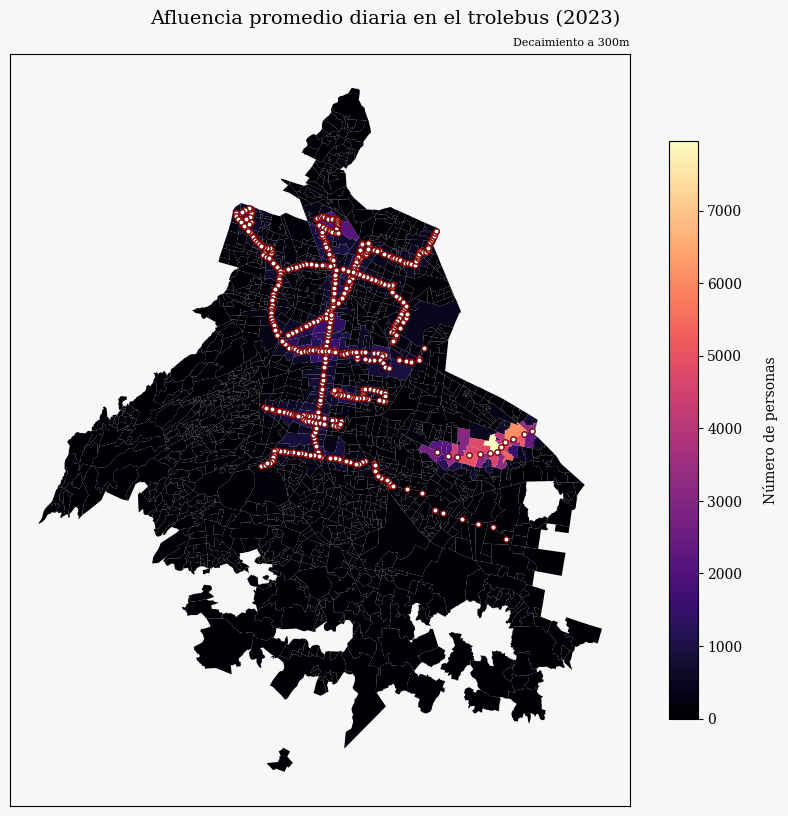

In [16]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'serif'

fig = plt.figure(figsize=(10, 15))

ax = colonias_afluencia.plot(column="prom_diario", ax=plt.gca(),
                             cmap='magma', legend=True,
                             legend_kwds={"shrink": 0.5})


metro.plot(ax=ax, color='azure', markersize=15, ec='maroon')


color_fondo = '#f7f7f7'
ax.set_facecolor(color_fondo)
fig.patch.set_facecolor(color_fondo)


ax.set_xticks([])
ax.set_yticks([])

plt.suptitle("Afluencia promedio diaria en el trolebus (2023)", y=0.775, fontsize=14)
plt.title('Decaimiento a 300m', loc='right', fontsize=8)

cax = ax.get_figure().get_axes()[1]
cax.set_ylabel('Número de personas', rotation=90, labelpad=15)

# Guardar el gráfico como una imagen (esta línea está comentada)
plt.savefig('/content/drive/MyDrive/Colonias CDMX/trolebus/mapa_trolebus_2023.png', dpi=300, bbox_inches='tight')

# Mostrar el gráfico
plt.show()